In [398]:
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

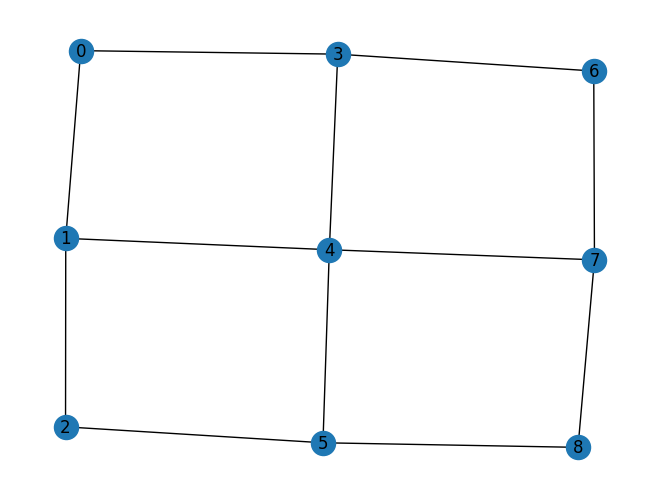

In [399]:
# Make square graph
l = 3
w = 3
n_qubits = l*w

G = nx.grid_graph((l,w))
G = nx.relabel_nodes(G, {e:i for i,e in enumerate(G.nodes)})

nx.draw(G, with_labels=True)

In [522]:
# Make XYZ Hamiltonian:
j1 = 1
j2 = 1
j3 = 1
h = 0.2

H = SparsePauliOp.from_sparse_list([('Z', [q], h) for q in G.nodes], num_qubits=len(G))
H += SparsePauliOp.from_sparse_list([('XX', e, j1) for e in G.edges], num_qubits=len(G))
H += SparsePauliOp.from_sparse_list([('YY', e, j2) for e in G.edges], num_qubits=len(G))
H += SparsePauliOp.from_sparse_list([('ZZ', e, j3) for e in G.edges], num_qubits=len(G))

In [523]:
H_mat = H.to_matrix(sparse=True)
true_gse, true_gs = sp.sparse.linalg.eigsh(H_mat, which='SA', k=1)
true_gse = true_gse[0]

In [524]:
d = 35 # Krylov dimension
H_norm = sp.sparse.linalg.norm(H_mat, ord=2)
dt = np.pi/H_norm
print('dt =',dt)

checkerboard_excitations = [l*r + i for r in range(w) for i in range(l) if i%2==r%2]
v0 = np.zeros(2**n_qubits, dtype=complex)
v0[sum([2**q for q in checkerboard_excitations])] = 1

dt = 0.16364755331082287


/Users/willkirby/Env/qiskit-1.0.1/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:482: UserWarning: Exited at iteration 20 with accuracies 
[0.00065224]
not reaching the requested tolerance 7.62939453125e-06.
Use iteration 21 instead with accuracy 
0.0006522359824647313.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/Users/willkirby/Env/qiskit-1.0.1/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:482: UserWarning: Exited postprocessing with accuracies 
[0.00065224]
not reaching the requested tolerance 7.62939453125e-06.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


In [525]:
# Construct Krylov vectors
v = [v0]
for i in range(d-1):
    ui = sp.sparse.linalg.expm_multiply(-1j*H_mat*dt, v[i])
    ui = ui/np.linalg.norm(ui)
    v.append(ui)

v = np.array(v).T

# Construct Krylov matrices
H_kry = np.conj(v).T @ H_mat @ v
S_kry = np.conj(v).T @ v

In [715]:
noise_rates = [10**(-x) for x in range(2,9)]
threshold_rescale = 0.1
reps = 10000

results = []
s_pert_norms = []
h_pert_norms = []

for r in noise_rates:
    results_by_rate = []
    s_pert_norms_by_rate = []
    h_pert_norms_by_rate = []

    for _ in range(reps):

        # Add Gaussian noise at rate r
        S_pert = np.exp(1j*np.random.uniform(0,2*np.pi)) * np.random.normal(scale=r, size=(d,d))
        S_pert = (S_pert+S_pert.T.conj())/2
        S_noisy = S_kry + S_pert

        H_pert = H_norm * np.exp(1j*np.random.uniform(0,2*np.pi)) * np.random.normal(scale=r, size=(d,d))
        H_pert = (H_pert+H_pert.T.conj())/2
        H_noisy = H_kry + H_pert

        s_pert_norms_by_rate.append(np.linalg.norm(S_pert, ord=2))
        h_pert_norms_by_rate.append(np.linalg.norm(H_pert, ord=2))

        approx_gs_energies = []

        # Look at all subspace dimensions up to d
        for _d in range(1,d+1):

            # Regularize by projecting onto good eigenspaces of S_kry
            s_vals, s_vecs = sp.linalg.eigh(S_noisy[:_d,:_d])
            s_vecs = s_vecs.T
            reg_transform = [vec for val, vec in zip(s_vals, s_vecs) if val > _d * threshold_rescale * r]
            if reg_transform is []:
                raise AssertionError('WHOLE SUBSPACE ILL-CONDITIONED')
            reg_transform = np.array(reg_transform).T
            H_reg = reg_transform.T.conj() @ H_noisy[:_d,:_d] @ reg_transform
            S_reg = reg_transform.T.conj() @ S_noisy[:_d,:_d] @ reg_transform

            # Solve generalized eigenvalue problem
            vals, vecs = sp.linalg.eigh(H_reg, S_reg)

            approx_gs_energies.append(min(vals))

        results_by_rate.append(approx_gs_energies)

    results.append(results_by_rate)
    s_pert_norms.append(s_pert_norms_by_rate)
    h_pert_norms.append(h_pert_norms_by_rate)

results = np.array(results)
s_pert_norms = np.array(s_pert_norms)
h_pert_norms = np.array(h_pert_norms)

In [716]:
# np.save('results', results)
# np.save('s_pert_norms', s_pert_norms)
# np.save('h_pert_norms', h_pert_norms)

# LOAD DATA FOR PLOTS IN PAPER

results = np.load('results.npy')
s_pert_norms = np.load('s_pert_norms.npy')
h_pert_norms = np.load('h_pert_norms.npy')

In [717]:
mean_results = {r:np.mean(v,axis=0) for r,v in zip(noise_rates,results)}
# mean of middle x percent of data
# mean_results = {r:np.mean(np.sort(v, axis=0)[int(0.1*reps):int(0.9*reps)],axis=0) for r,v in results.items()}
median_results = {r:np.median(v,axis=0) for r,v in zip(noise_rates,results)}

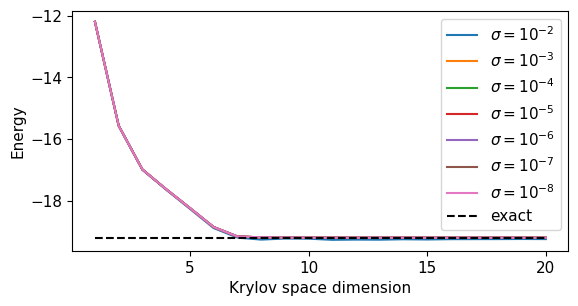

In [718]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

for r in noise_rates:
    plt.plot(range(1,21), median_results[r][:20], label=r'$\sigma=10^{{{}}}$'.format(int(np.log10(r))))

plt.plot(range(1,21), [true_gse for _ in range(1,21)], label='exact', color='k', linestyle='dashed')

plt.xticks(list(range(5,21,5)))
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.legend()

plt.gca().set_aspect(1.3)
plt.savefig('convergence_plot.pdf', bbox_inches='tight')

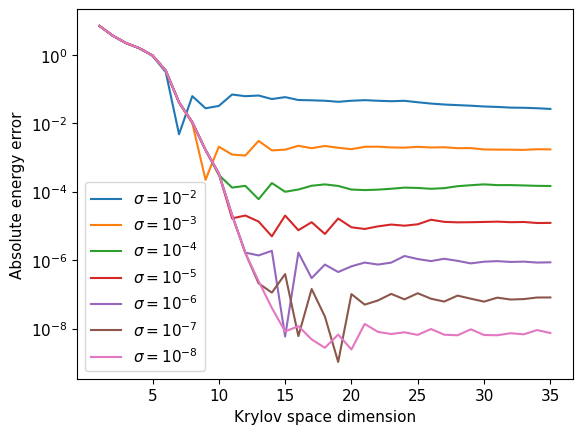

In [719]:
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

for i,r in enumerate(noise_rates):
    plt.plot(range(1,d+1), np.abs(median_results[r]-true_gse), label=r'$\sigma=10^{{{}}}$'.format(int(np.log10(r))))
plt.yscale('log')
plt.xticks(list(range(5,d+1,5)))
plt.xlabel('Krylov space dimension')
plt.ylabel('Absolute energy error')
plt.legend()

plt.savefig('convergence_plot_log.pdf', bbox_inches='tight')

In [720]:
def upper_bound(H_norm, overlap, d, delta, delta_prime, Delta_prime, chi, zeta):
    term0 = delta_prime if delta_prime > Delta_prime else 0
    term1 = (1/overlap)*(1+6*H_norm/(delta_prime-delta))*chi
    term2 = (6*H_norm/overlap)*zeta
    term3 = (6*H_norm/overlap)*8*(1+0.5*np.pi*delta/H_norm)**(-2*d)
    out = term0+term1+term2+term3
    return out

In [721]:
mean_s_pert = {r:np.mean(v) for r,v in zip(noise_rates,s_pert_norms)}
mean_h_pert = {r:np.mean(v) for r,v in zip(noise_rates,h_pert_norms)}

chis = {r:mean_h_pert[r] + H_norm * mean_s_pert[r] for r in noise_rates}
zetas = {r:2 * d * (d * threshold_rescale * r + mean_s_pert[r]) for r in noise_rates}

In [722]:
overlap = np.abs(true_gs.T[0] @ v0)**2
print('overlap =',overlap,'\n')
overlap_primes = {r:overlap - 2 * d * threshold_rescale * r - 2 * mean_s_pert[r] for r in noise_rates}
print('overlap_primes =',overlap_primes,'\n')
Delta = np.diff(sp.sparse.linalg.eigsh(H_mat, which='SA', k=2)[0:2][0])[0]
print('spectral gap =',Delta,'\n')
Delta_primes = {r:Delta - chis[r]/overlap_primes[r] for r in noise_rates}

bounds = {}
for r in noise_rates:
    def upper_bound_fn(x):
        return upper_bound(H_norm, overlap_primes[r], d, x[0], x[1], Delta_primes[r], chis[r], zetas[r])
    
    # Minimize over values of delta and delta_prime:
    min_bound = sp.optimize.minimize(
        upper_bound_fn,
        method='COBYLA',
        x0=(Delta_primes[r]/2,Delta_primes[r]),
        bounds=((0,None),(Delta_primes[r]-0.01,None)),
        constraints=(
            {'type': 'ineq', 'fun': lambda x:  x[1]-x[0]-chis[r]/overlap_primes[r]}
            )
        )
    
    print('term3 =', (6*H_norm/overlap)*8*(1+0.5*np.pi*min_bound.x[0]/H_norm)**(-2*d))

    bounds[r] = min_bound.fun

bounds

overlap = 0.27533219074476223 

overlap_primes = {0.01: 0.04770652762525723, 0.001: 0.25255962872822113, 0.0001: 0.27305479392929477, 1e-05: 0.27510440760634886, 1e-06: 0.27530943495802496, 1e-07: 0.27532991415679586, 1e-08: 0.275331962997435} 

spectral gap = 0.3999999999999737 

term3 = 1.6244156692443923e+176
term3 = 0.18433589173348844
term3 = 0.19892348924500672
term3 = 0.20042930819223193
term3 = 0.2006982177976648
term3 = 0.20137131745126832
term3 = 0.20214867184804866


{0.01: 9.375109595199049e+176,
 0.001: 390.24340437101,
 0.0001: 42.90701495704755,
 1e-05: 7.62322381909257,
 1e-06: 3.067524404804905,
 1e-07: 2.2800084844799193,
 1e-08: 2.0960641048144995}

As the above cell illustrates, with the optimal choices of `delta` and `delta_prime`, the final term (`term3`) is still not converged to zero. This is the term that corresponds to the error from projection into the Krylov space, which converges as `d` increases, and we can see from the plot a few cells above that it has in fact converged, showing that that term in the upper bound is overly pessimistic in its convergence rate. Since we primarily care about the effect of noise, to get a bound to compare to the data we leave out `term3`, which amounts to assuming that the projection error has in fact converged (as we can see in the plot above).

In order to avoid an unrealistic value, we can no longer minimize over `delta` and `delta_prime`, since the minimizer would choose `delta=0` without `term3` to provide a penalty for this. Instead we choose `delta` and `delta_prime`to be `Delta_primes[r]/2` and `Delta_primes[r]`, respectively, since these are good representative choices for the reasons discussed in the paper (for the largest two noise rates, `Delta_primes[r]` is negative, so we instead use `Delta/2` and `Delta`).

In [723]:
def upper_bound_without_term3(H_norm, overlap, d, delta, delta_prime, Delta_prime, chi, zeta):
    term0 = delta_prime if delta_prime > Delta_prime else 0
    term1 = (1/overlap)*(1+6*H_norm/(delta_prime-delta))*chi
    term2 = (6*H_norm/overlap)*zeta
    return term0+term1+term2

In [724]:
bounds = {}
for r in noise_rates:
    if Delta_primes[r] > 0:
        bounds[r] = upper_bound_without_term3(H_norm, overlap_primes[r], d, Delta_primes[r]/2, Delta_primes[r], Delta_primes[r], chis[r], zetas[r])
    else:
        bounds[r] = upper_bound_without_term3(H_norm, overlap_primes[r], d, Delta/2, Delta, Delta_primes[r], chis[r], zetas[r])

bounds

{0.01: 55852.04699322927,
 0.001: 1055.5865411242974,
 0.0001: 122.13344534329133,
 1e-05: 9.870908514695365,
 1e-06: 0.9691247712822023,
 1e-07: 0.09675658483514893,
 1e-08: 0.009678337820188374}

In [725]:
# lower bound value
{r:(mean_h_pert[r] + (1+np.sqrt(2)) * H_norm * mean_s_pert[r])/(d * threshold_rescale * r) for r in noise_rates}

{0.01: 147.64445276975567,
 0.001: 147.68738551779145,
 0.0001: 147.71797923971204,
 1e-05: 147.75556241222392,
 1e-06: 147.57231875716175,
 1e-07: 147.60270570462245,
 1e-08: 147.6782284010933}

In [726]:
# break up data into positive and negative errors, collecting all of the points from the last ten dimensions
positive_errors = {}
negative_errors = {}
for r,v in zip(noise_rates,results):
    positive_errors[r] = []
    negative_errors[r] = []
    for _d in range(d-10, d):
        for energy in v.T[_d]:
            error = energy-true_gse
            if error >= 0:
                positive_errors[r].append(error)
            else:
                negative_errors[r].append(error)

print([len(v) for v in positive_errors.values()])
print([len(v) for v in negative_errors.values()])

[11090, 22186, 26656, 29306, 34886, 37064, 37298]
[88910, 77814, 73344, 70694, 65114, 62936, 62702]


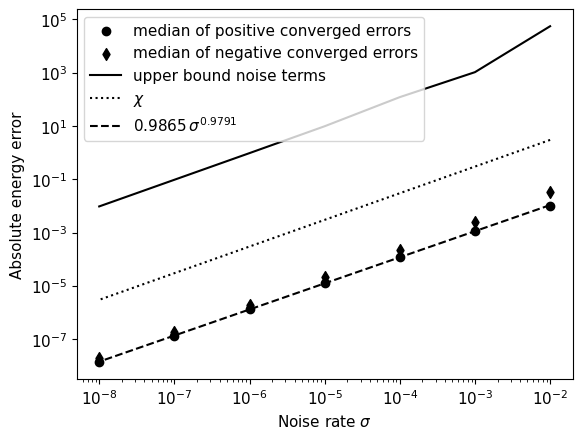

In [727]:
plt.scatter(noise_rates, [np.median(positive_errors[r]) for r in noise_rates], label='median of positive converged errors', color='k')
plt.scatter(noise_rates, [-np.median(negative_errors[r]) for r in noise_rates], label='median of negative converged errors', color='k', marker='d')

plt.plot(noise_rates, bounds.values(), label='upper bound noise terms', color='k')
plt.plot(noise_rates, chis.values(), label=r'$\chi$', color='k', linestyle='dotted')

def f(x, m, b):
    return m*x+b

popt, pcov = sp.optimize.curve_fit(f, np.log(np.array(noise_rates)), np.log(np.array([np.median(positive_errors[r]) for r in noise_rates])))

plt.plot(noise_rates, [np.exp(popt[1])*(r**popt[0]) for r in noise_rates], label=r'${}\,\sigma^{{{}}}$'.format(np.round(np.exp(popt[1]),4),np.round(popt[0],4)), color='k', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Noise rate $\sigma$')
plt.ylabel('Absolute energy error')
plt.legend()

plt.savefig('bound_example.pdf', bbox_inches='tight')